<a href="https://colab.research.google.com/github/paulo-g-martinez/vis-big-data/blob/main/vis_big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

6/19/21 Paulo G. Martinez

# Objective: I want to plot and display data that is too big for memory.

# Background
- **I've tried "stepwise" reading subsets of the data into memory, plotting subplots, then deleting the data subset (within memory limits). But I'm still exceeding the memory.**
  - I suspect this is because while I delete the data itself, a "transformed version" of the data is necessarily retained as an element of the axes or figure
    - this is likely even "bigger" for null heatmaps where every column _m_ X _1_ (ex: array of booleans) probably becomes a _2m_ X _2_ array of rectangles or whatever.

# Strategy:
- Since I only want the visualization (not the data),

**(First loop) plot subsets only:**
- I'll plot each subset of the data
- export the viz to disk as an image (jpg etc.)
  - hoping for a visual resolution that is good enough for human eyes but less data than the full set of coordinates etc for each point in the plot
- drop the data from memory and clear the subplot/figure

**(Optional Second loop) display images only, without data:**
- then read only the image into memory and write that to the subplot/figure



# Conclusion ✅ 🎉 😎 
- I didn't have to save the images to disk after all!
  - hacked the margins to make many plots seem like one

## When applying to actual projects
### nuance these inputs to the function
- change the exception handling to an exception that corresponds to the memory overflow
- add the logic to read the actual big data

# Imports and global variables

In [ ]:
# for data frames
import pandas as pd
import numpy as np
# for figure and subplot management
import matplotlib.pyplot as plt
# for very granular aesthetic configurations
import matplotlib as mpl
# for easy heatmaps
import seaborn as sns

# declare local limit 
local_limit = 60 # (in practice, likely an error to handle)
# feedback to print
verbose = 100
concerned_about_memory = True
debugging = False
# max number of recursions
max_recursions = 4

## get data
Just dummy data, for now.

In [ ]:
# get iris data set for ease
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
# sprinkle some nulls in there
for col in df:
  # only for numeric cols
  if df[col].dtype == "float64":
    # simply cast rounded even ints to null
    df[col] = df[col].apply(lambda f: None if int(f)%2 == 0 else f)
# spot check
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,NaN,setosa
1,NaN,3.0,1.4,NaN,setosa
2,NaN,3.2,1.3,NaN,setosa
3,NaN,3.1,1.5,NaN,setosa
4,5.0,3.6,1.4,NaN,setosa


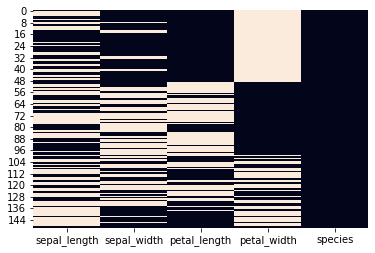

In [ ]:
# check global heatmap
sns.heatmap(df.isna(), cbar = False)

# define, dev, test: logic to recursively try
- Assume we don't know exactly what our local memory limits are and define an approach that recursively adjusts until it succeeds.


## local inputs

In [ ]:
# count rows in big data
big_row_count = df.shape[0]

## Attempt to display withou having to save
(hack the plotting margins to create the illusion of a single plots from many contiguous plots)

recursion:1
-----------
set num_of_subsets to: 1
! subset_row_limit: 150 exceeded local limit.
  decreased to: 76 for next recursion.

recursion:2
-----------
set num_of_subsets to: 2
! subset_row_limit: 76 exceeded local limit.
  decreased to: 39 for next recursion.

recursion:3
-----------
set num_of_subsets to: 4


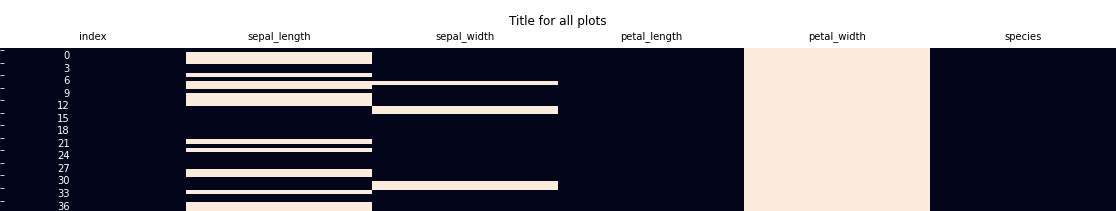

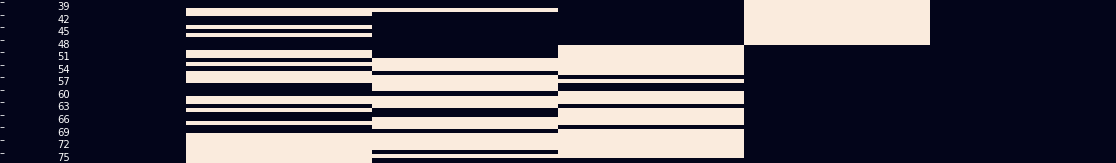

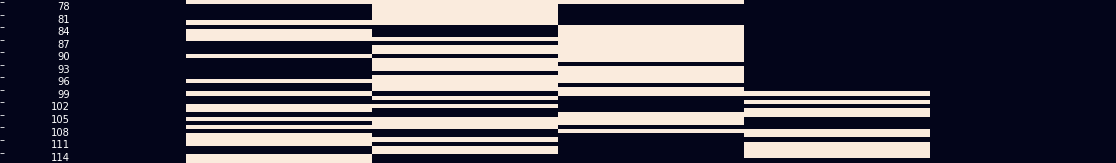

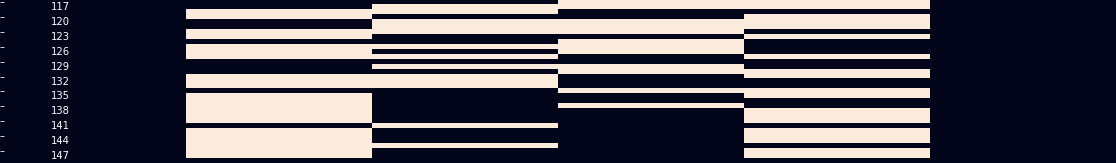

>> Success! breaking recursion...<<


In [ ]:
# recursively do stuff
######################
i_recursion = 0
while i_recursion <= max_recursions:
  # track current recursion
  i_recursion += 1
  if verbose:
    feedback = f"recursion:{i_recursion}"
    feedback += '\n'+'-'*len(feedback)
    print(feedback)

  # do stuff
  # ========
  # will try the whole thing first
  if i_recursion == 1:
    subset_row_limit = big_row_count
  # determine number of subsets
  num_of_subsets = int(np.ceil(big_row_count/subset_row_limit))
  if verbose:
    feedback = f"set num_of_subsets to: {num_of_subsets}"
    print(feedback)
  
  # try stuff
  # ---------
  try: 
    # iterate through subsets (don't print or you'll interrupt the ilussion of many plots being one)
    for i in range(num_of_subsets):
      # define subset limits
      start, stop = i*subset_row_limit, (i+1)*subset_row_limit

      # dummy limit test
      if subset_row_limit > local_limit:
        raise AssertionError

      # read the data subset
      # reset the index to make it a non null background column for ytick labels
      sub_df = df.reset_index()[start:stop]
      
      # heatmap the data
      fig, ax = plt.subplots(figsize = (20,int(15/num_of_subsets)))
      sns.heatmap(sub_df.isna(),
                  cbar = False,
                  ax = ax)
      
      # fine tune aesthetic parameters to make many plots look like one
      # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
      # remove the default 0.1 padding around the figure itself
      mpl.rcParams['savefig.pad_inches'] = 0
      # new lines act as hardcoded margins
      #ax.set_ylabel(f'\nrows:{start}-{stop}', ha = 'right')
      
      # if first subset
      if i == 0:
        # add a title (prefix new line creates a top margin)
        ax.set_title('\nTitle for all plots')
        # set x labels (col names) to top
        plt.tick_params(axis = 'x', labeltop = True)
      
      # for all subsets
      ax.tick_params( 
        axis = 'x', 
        # turn off major and minor bottom ticks and lables
        which = 'both',
        bottom = False,
        top = False, 
        labelbottom = False,
      )
      # aggressive inner padding to prevent unwanted horizontal margins
      # (if lenght of the ytick labels is of uneven length between plots
      # then the axis will be "squeezed" to accomodate them this will visually
      # misalign the the appearence of "columns" between plots)
      ax.tick_params(axis = 'y', direction = 'in', pad = -70, color = 'white',
                     labelcolor = 'white', labelrotation = 0)
      # align the yticks to their top to prevent unwanted margin space above img
      plt.yticks(va = 'top', color = 'white')
      
      if debugging:
        # alternating background color helps in margin tuning
        fig.set_facecolor(['red', 'blue'][i%2])

      plt.show()
      # drop unwanted objects from memory
      if concerned_about_memory: 
        plt.close(fig)
        del fig, ax, sub_df
      # restore the default plotting margin
      mpl.rcParams['savefig.pad_inches'] = 0.1
    
    print('>> Success! breaking recursion...<<')
    break
  
  # handle error from trying (exceeding local limit)
  # ------------------------------------------------
  except AssertionError:
    feedback = f'! subset_row_limit: {subset_row_limit} exceeded local limit.'
    subset_row_limit = int(subset_row_limit/2) + 1
    feedback += f'\n  decreased to: {subset_row_limit} for next recursion.'
    print(feedback)
  
  # end of while loop iteration
  # ===========================
  print()

# Success!

# Refactor into a function for easier use

In [ ]:
pd.DataFrame()

""


In [ ]:
def incrementally_heatmap_big_data(sliceable_big_df,
                                   big_row_count,
                                   max_recursions = 4,
                                   exceed_memory_err_type = AssertionError,
                                   title = 'Heatmap of big data',
                                   figsize = (20, 15),
                                   verbose = True, 
                                   concerned_about_memory = True, 
                                   debugging = False,
                                   ret_obj = True):
  """Heatmaps a big data frame recursively subsampling as required by memory.

  Some assembly required.
  Takes a reference to a data set that is too big to plot as one object.
  Attempts to plot the whole object. When that raises the exception specified as
  `exceed_memory_err_type` it will define two slicing indices that define two 
  subsets of the original data. It then tries to plot each subset as its own
  `fig, ax` objects. But it configures the plotting margins and inline display
  to produce an image which appears to be a single `fig` object. This process
  repeats recursively until it either succeeds at plotting the data or it
  reaches the maximum number of recursions specified.

  Parameters
  ----------

  # sliceable_big_df : You'll have to nuance this!
    but it should reference a big 
    data set that can be somehow sliced or subseted without calling the entire 
    data into memory

  big_row_count : an integer expressing the number of rows/records in the big
    data set.

  max_recursions : The number of times you want to try to subset and plot the
    big data. The first attempt uses a single subset equivalent to the whole
    data. The second attempt uses two subsets. The third attempt uses 4 subsets.
    Each attempt doubles the number us subsets attempted. Defaults to 4, which 
    would max out at 16 subsets of the data.
    
  # exceed_memory_err_typ : You'll have to nuance this!
    the error type your local environment raises when you exceed your local 
    memory limit. Defaults to AssertionError.

  title : String title of the heatmap.

  figsize : tuple of width and height passed to plt.subplots

  verbose : boolean or number expressing whether or not you want the function to
    print some feedback.

  concerned_about_memory : Boolean flag telling the function to drop data from 
    local memory as soon as it can.
   
  debugging : Boolean flag, if true will alternate the backgrounds of the plots 
    between red and blue as a visual aid to fine tune the "margin hacking."

  ret_obj : Boolean flag. Not really used, function will return this right back
    to you.
  """
  # validate inputs
  assert int(big_row_count) > 0
  assert type(int(max_recursions)) == int
  assert type(verbose) in {int, bool}
  assert type(concerned_about_memory) in {int, bool}
  assert type(debugging) in {int, bool}
  assert type(ret_obj) in {bool}
  # we won't validate the type of sliceable_big_df cause I just want it to be 
  # some object that when called returns a sliceable dataframe
  # I don't want to call the dataframe that, by stipulation, is expected to be 
  # so big it would exceed our local memory

  # recursively do stuff
  ######################
  i_recursion = 0
  while i_recursion <= max_recursions:
    # track current recursion
    i_recursion += 1
    if verbose:
      feedback = f"recursion:{i_recursion}"
      feedback += '\n'+'-'*len(feedback)
      print(feedback)

    # do stuff
    # ========
    # will try the whole thing first
    if i_recursion == 1:
      subset_row_limit = big_row_count
    # determine number of subsets
    num_of_subsets = int(np.ceil(big_row_count/subset_row_limit))
    if verbose:
      feedback = f"set num_of_subsets to: {num_of_subsets}"
      print(feedback)
    
    # try stuff
    # ---------
    try: 
      # iterate through subsets (don't print or you'll interrupt the ilussion of many plots being one)
      for i in range(num_of_subsets):
        # define subset limits
        start, stop = i*subset_row_limit, (i+1)*subset_row_limit

        # read the data subset
        ####################################################################
        # You'll have to nuance this for however you access your big data) #
        ####################################################################
        # reset the index to make it a non null background column for ytick labels
        sub_df = sliceable_big_df.reset_index()[start:stop] 
        # we expect this call to fail on the first pass
        
        # init plotting objects
        fig, ax = plt.subplots(
            figsize = (
                figsize[0],
                int(np.ceil(figsize[1]/num_of_subsets))
            )
        )
        # heatmap the data
        sns.heatmap(sub_df.isna(),
                    cbar = False,
                    ax = ax)
        if concerned_about_memory:
          del sub_df
        # fine tune aesthetic parameters to make many plots look like one
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        # remove the default 0.1 padding around the figure itself
        mpl.rcParams['savefig.pad_inches'] = 0
        # new lines act as hardcoded margins
        #ax.set_ylabel(f'\nrows:{start}-{stop}', ha = 'right')
        
        # if first subset
        if i == 0:
          # add a title (prefix new line creates a top margin)
          ax.set_title('\n'+title)
          # set x labels (col names) to top
          plt.tick_params(axis = 'x', labeltop = True)
        
        # for all subsets
        ax.tick_params( 
          axis = 'x', 
          # turn off major and minor bottom ticks and lables
          which = 'both',
          bottom = False,
          top = False, 
          labelbottom = False,
        )
        # aggressive inner padding to prevent unwanted horizontal margins
        # (if lenght of the ytick labels is of uneven length between plots
        # then the axis will be "squeezed" to accomodate them this will visually
        # misalign the the appearence of "columns" between plots)
        ax.tick_params(axis = 'y', direction = 'in', pad = -70, color = 'white',
                      labelcolor = 'white', labelrotation = 0)
        # align the yticks to their top to prevent unwanted margin space above img
        plt.yticks(va = 'top', color = 'white')
        
        if debugging:
          # alternating background color helps in margin tuning
          fig.set_facecolor(['red', 'blue'][i%2])

        plt.show()
        # drop unwanted objects from memory
        if concerned_about_memory: 
          plt.close(fig)
          del fig, ax
        # restore the default plotting margin
        mpl.rcParams['savefig.pad_inches'] = 0.1
      
      if verbose:
        print('>> Success! breaking recursion...<<')
      break
    
    # handle error from trying (exceeding local limit)
    # ------------------------------------------------
    except exceed_memory_err_type:
      feedback = f'! subset_row_limit: {subset_row_limit} exceeded local limit.'
      subset_row_limit = int(subset_row_limit/2) + 1
      feedback += f'\n  decreased to: {subset_row_limit} for next recursion.'
      print(feedback)
    
    # end of while loop iteration
    # ===========================
    print()
  
  return ret_obj

## test

In [ ]:
# for data frames
import pandas as pd
import numpy as np
# for figure and subplot management
import matplotlib.pyplot as plt
# for very granular aesthetic configurations
import matplotlib as mpl
# for easy heatmaps
import seaborn as sns

In [ ]:
# get iris data set for ease
big_df = sns.load_dataset('iris').drop(columns = 'species').applymap(lambda f: None if int(f)%2 == 0 else f)
big_df

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,NaN
1,NaN,3.0,1.4,NaN
2,NaN,3.2,1.3,NaN
3,NaN,3.1,1.5,NaN
4,5.0,3.6,1.4,NaN
...,...,...,...,...
145,NaN,3.0,5.2,NaN
146,NaN,NaN,5.0,1.9
147,NaN,3.0,5.2,NaN
148,NaN,3.4,5.4,NaN


recursion:1
-----------
set num_of_subsets to: 1


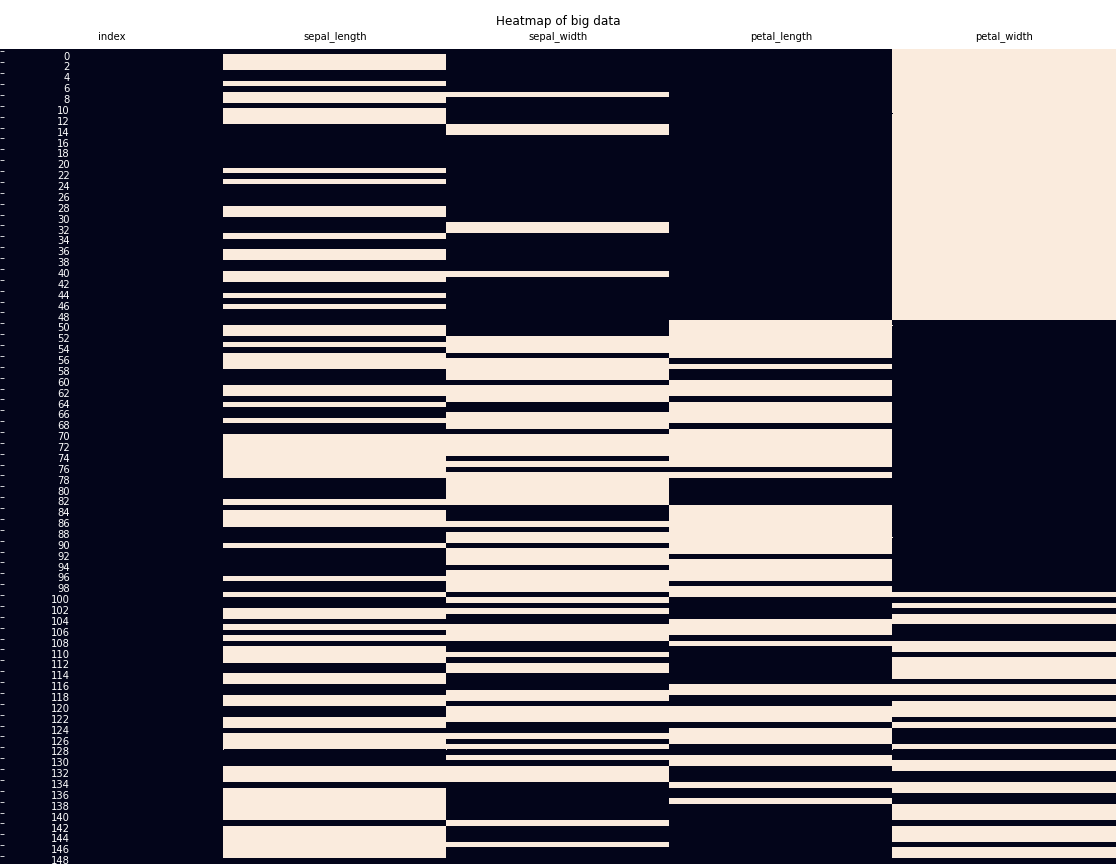

>> Success! breaking recursion...<<


True

In [ ]:
incrementally_heatmap_big_data(sliceable_big_df=sns.load_dataset('iris').drop(columns = 'species').applymap(lambda f: None if int(f)%2 == 0 else f), 
                               big_row_count=sns.load_dataset('iris').shape[0])